# **Description**
In this notebook we want to classifiy set of user messages about stock market.

Our data is persian text and we FastText embedding to vectorize messages.

In [ ]:
!pip install hazm
!pip install parsivar
!pip install fasttext
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 29.0 MB/s 
     |████████████████████████████████| 1.4 MB 55.7 MB/s 
     |████████████████████████████████| 233 kB 69.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=d9b8258de7ac04770ca0c41f94359a4295a0f906f1e8aa1965daece343470404
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154914 sha256=29233e0b533505cbb75d119509abbf0336dfa6e29f15827a9da7308c53f3f93b
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https:/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# labels_to_id = {0:0,
#                "question":1,
#                 "news":2,
#                 "new":2,
#                 "news_official":2,
#                 'news_offcial':2,
#                 "analysis_technical":3,
#                 "analysis_fun":3,
#                 "analysis":3,
#                 "buy":4,
#                 "buy_lc":4,
#                 "predict+":5,
#                 "predict-":6,
#                 "sell":7,
#                 "report_st":8,
#                 "report_loss":9,
#                 "report_profit":10,
#                 'predict_profit':10,
#                 "report_per":11,
#                 "hold":12,
#                 "watch":13,
#                 "take_profit":14,
#                 "statistics":15,
#                 }
# id_2_labels = {0:0,
#                1:"question",
#                2: "news",
#               3:"analysis",
#               4 : "buy",
#                 5:"predict+",
#                 6:"predict-",
#                 7:"sell",
#                 8:"report_st",
#                 9:"report_loss",
#                 10:"report_profit",
#                 11:"report_per",
#                 12:"hold",
#                 13:"watch",
#                 14:"take_profit",
#                 15:"statistics",

#                 }
labels_to_id = {0:0,
               "question":1,
                "news":2,
                "new":2,
                "news_official":2,
                'news_offcial':2,
                "analysis_technical":3,
                "analysis_fun":3,
                "analysis":3,
                "buy":4,
                "buy_lc":4,
                "predict+":5,
              #  "predict-":6,
              #  "sell":7,
                "report_st":6,
                "report_loss":7,
                "report_profit":8,
                "report_per":9,
              #  "hold":12,
                "watch":10,
              # "take_profit":14,
                "statistics":11,
                }
id_2_labels = {0:0,
               1:"question",
               2: "news",
              3:"analysis",
              4 : "buy",
                5:"predict+",
                #6:"predict-",
                #7:"sell",
                6:"report_st",
                7:"report_loss",
                8:"report_profit",
                9:"report_per",
                #12:"hold",
                10:"watch",
                #14:"take_profit",
                11:"statistics",
                }

# stop_words = {""}
num_of_class = 12
max_len = 30

In [ ]:
import os
os.chdir("/content/drive/MyDrive/master_project")

In [ ]:
import fasttext
model_skipgram = fasttext.load_model('farsi-dedup-skipgram.bin')

# data perparation

In [ ]:
import pandas as pd
import numpy as np
import re
from torch.utils.data import Dataset,DataLoader

from hazm import Normalizer, WordTokenizer
from parsivar import FindStems,POSTagger
from gensim.models import Word2Vec,TfidfModel, LdaModel
from gensim.corpora import Dictionary


In [ ]:

import math
class Data_load():
    def __init__(self,max_len ):
          self.max_len = max_len
          self.sentence_embedding = []
          self.dictionary = None
          self.BoW_corpus = None

    def load_data(self):
      messages_file = pd.read_excel("/content/drive/MyDrive/master_project/classification_data/reduced_data.xlsx")
      messages_file.dropna()
      nrmlizr = Normalizer()
      tokenizer =  WordTokenizer()
      stemmer = FindStems()
      tagger = POSTagger(tagging_model="wapiti")
      print(messages_file.columns)
      l = 0
      docs = []
      for i in range(len(messages_file)):
          vocab = []
          words = tagger.parse(tokenizer.tokenize(messages_file.loc[i, "message"]))
          clean_words = []
          for w in words:
            w[0] == w[0].replace("_","\u200c").strip("\u200c").strip("\u200e")
            if w[1] not in ["V_AUX","V_PA","V_PRE", "V_PRS", "V_SUB"] and len(w[0])>1:
                stemm = stemmer.convert_to_stem(w[0], word_pos = "N")
                clean_words.append(stemm)
                vocab.append(stemm)
            elif len(w[0])>1 or w[0]== "?":
                clean_words.append(w[0])
                vocab.append(w[0])
          docs.append(vocab)
          l += len(clean_words)
          messages_file.loc[i, "message"] = clean_words
      self.labels = messages_file['label'].values
      self.text = []
      self.dictionary = Dictionary(docs)
      #new_docs = []
      for text in docs:
        #print(text)
        #t = [w for w in text if self.dictionary.dfs[self.dictionary.token2id[w]]> 2 ]
        #new_docs.append(t)
        self.text.append(text)
      #self.dictionary = Dictionary(new_docs)
      self.BoW_corpus= [self.dictionary.doc2bow(t) for t in docs]


    def text_digit(self):
      self.X = []
      self.Y = []
      self.Z = []
      tfidf = TfidfModel(self.BoW_corpus)
      z = 0
      for msg,label in zip(self.BoW_corpus, self.labels):
        # print(msg)
        label = str(label).strip().lower() if label != 0 else label
        tf_idf_vec = tfidf[msg]
        vector = np.zeros(100)
        count = 0
        j = 0
        for word_tfidf in tf_idf_vec:
            try:
              vector += word_tfidf[1] * np.array(model_skipgram[self.dictionary[word_tfidf[0]]])
              count += word_tfidf[1]

            except KeyError:
                print(self.dictionary[word_tfidf[0]])
                continue
            except TypeError:
                print(type(model_skipgram[self.dictionary[word_tfidf[0]]]),model_skipgram[self.dictionary[word_tfidf[0]]])
        if label in ["sell","predict-","statistics","take_profit","hold"]:
          for j in range(3):
              self.Z.append(self.text[z])
              self.X.append(vector/count if count != 0 else vector)
              self.Y.append(labels_to_id[label])

        else:
          self.Z.append(self.text[z])
          self.X.append(vector/count if count != 0 else vector)
          self.Y.append(labels_to_id[label])
        z += 1

class Message_Dataset(Dataset):
      def __init__(self, X, Y):
         self.messages = X
         self.labels = Y

      def __len__(self):
         return len(self.labels)

      def __getitem__(self, index):
          text = torch.tensor(self.messages[index])
          label = torch.tensor(self.labels[index])
          return text, label

In [ ]:
dataset_loader_drive = Data_load(50)
dataset_loader_drive.load_data()

Index(['message', 'label'], dtype='object')


In [ ]:
dataset_loader_drive.text_digit()

In [ ]:
del model_skipgram

In [ ]:
import random
temp = list(zip(dataset_loader_drive.X, dataset_loader_drive.Y, dataset_loader_drive.Z))
random.shuffle(temp)
res1, res2,res3 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
X, Y, Text = list(res1), list(res2),list(res3)

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
dataset_len =  len(X)

In [ ]:
x_train,x_test, y_train, y_test = X[:int(0.8*dataset_len)], X[int(0.8*dataset_len):], Y[:int(0.8*dataset_len)], Y[int(0.8*dataset_len):]
text_test = Text[int(0.8*dataset_len):]
text_train =  Text[:int(0.8*dataset_len)]
print(len(y_train), len(y_test))
svm_model = SVC(kernel="rbf")
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(mt.classification_report(y_test,y_pred,labels= [i for i in range(0,num_of_class)]))
print(mt.confusion_matrix(y_test,y_pred,labels= [i for i in range(0,num_of_class)]))
# for p,t,m in zip(y_pred,y_test,text_test):
#   print(p,t,m)
pd.DataFrame({"message":text_test,"true":y_test,"predict":y_pred}).to_excel("svm_label_result.xlsx")

6990 1748


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.40      0.68      0.51       214
           1       0.78      0.82      0.80       319
           2       0.76      0.84      0.80       167
           3       0.63      0.61      0.62       133
           4       0.49      0.51      0.50       120
           5       0.45      0.16      0.24       123
           6       0.49      0.60      0.54       248
           7       0.56      0.24      0.34        83
           8       0.00      0.00      0.00        47
           9       0.57      0.40      0.47        57
          10       0.70      0.44      0.54        68
          11       0.94      0.82      0.88       169

    accuracy                           0.61      1748
   macro avg       0.56      0.51      0.52      1748
weighted avg       0.61      0.61      0.60      1748

[[146  21   5   4   5   3  26   2   0   0   2   0]
 [ 32 261   0   2   7   5   8   2   0   1   1   0]
 [ 11   7 141   2   1   1   2  

In [ ]:
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
print(mt.classification_report(y_test,knn.predict(x_test),labels= [i for i in range(0,num_of_class)]))
for y,x,t in zip(y_test[:100],x_test[:100], text_test[:100]):
    print(y,t)
    y_pred = knn.kneighbors([x],3)
    for i in y_pred[1][0]:
      print(y_train[i],text_train[i])
    print("********************************************************")



              precision    recall  f1-score   support

           0       0.29      0.74      0.42       214
           1       0.75      0.66      0.70       319
           2       0.66      0.71      0.68       167
           3       0.37      0.64      0.47       133
           4       0.51      0.34      0.41       120
           5       0.32      0.09      0.14       123
           6       0.61      0.27      0.37       248
           7       0.45      0.11      0.17        83
           8       0.33      0.13      0.18        47
           9       0.52      0.25      0.33        57
          10       0.67      0.26      0.38        68
          11       0.81      0.95      0.88       169

    accuracy                           0.51      1748
   macro avg       0.52      0.43      0.43      1748
weighted avg       0.56      0.51      0.50      1748

6 ['فیلتر', 'نمادبورسی', 'ورود', 'پول', 'هوشمند']
6 ['فیلتر', 'نمادبورسی', 'ورود', 'پول', 'هوشمند']
6 ['فیلتر', 'نمادبورسی', 'ورود', 

# data represantation

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8738 samples in 0.001s...
[t-SNE] Computed neighbors for 8738 samples in 2.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8738
[t-SNE] Computed conditional probabilities for sample 2000 / 8738
[t-SNE] Computed conditional probabilities for sample 3000 / 8738
[t-SNE] Computed conditional probabilities for sample 4000 / 8738
[t-SNE] Computed conditional probabilities for sample 5000 / 8738
[t-SNE] Computed conditional probabilities for sample 6000 / 8738
[t-SNE] Computed conditional probabilities for sample 7000 / 8738
[t-SNE] Computed conditional probabilities for sample 8000 / 8738
[t-SNE] Computed conditional probabilities for sample 8738 / 8738
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.363411
[t-SNE] KL divergence after 1000 iterations: 2.430555


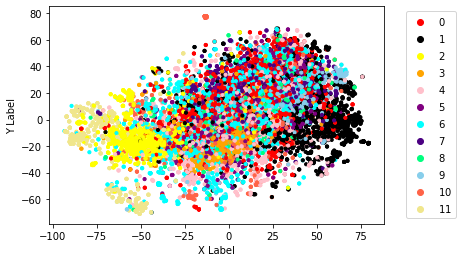

In [ ]:
from  sklearn.cluster import KMeans
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(np.array(dataset_loader_drive.X))
# data ={}
# data["ID"] = [i for i in range(len(kmean.labels_))]
# data["Label"] = kmean.labels_
# for i in range(1,4):
#   data[i] = z[:,i-1]
# data = pd.DataFrame(data)

data ={}
data["ID"] = [i for i in range(len(dataset_loader_drive.Y))]
data["Label"] = dataset_loader_drive.Y
for i in range(1,3):
  data[i] = z[:,i-1]
data = pd.DataFrame(data)
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


# generate data
n = 200
x = z[:,0]
y = z[:,1]


# axes instance
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# get colormap from seaborn
cmap = ["red", "black",
        "yellow","blue",
        "orange", "pink",
        "gray", "purple",
        "cyan","green",
        "indigo", "springgreen",
        "crimson", "skyblue",
        "tomato","khaki" ]
cmap = ListedColormap(cmap)
# plot

plt.savefig("scatter_hue", bbox_inches='tight')
sc = plt.scatter(x, y, s=10, c=data["Label"]

                ,  cmap=cmap, alpha=1)
plt.xlabel('X Label')
plt.ylabel('Y Label')
# ax.set_zlabel('Z Label')



# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
# for i in range(1,4):
#   data[i] = z[:,i-1]
# data = pd.DataFrame(data)
# import re, seaborn as sns
# import numpy as np

# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# # generate data
# n = 200
# x = z[:,0]
# y = z[:,1]
# v = z[:,2]

# # axes instance
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig)
# fig.add_axes(ax)

# # get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# # plot
# sc = ax.scatter(x, y, v, s=40, c=kmean.labels_
#                 ,  cmap=cmap, alpha=1)
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')



# # legend
# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# # save
# plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
tsne = TSNE(n_components=
            3, verbose=1, random_state=123)
z = tsne.fit_transform(np.array(dataset_loader_drive.X))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8738 samples in 0.002s...
[t-SNE] Computed neighbors for 8738 samples in 2.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8738
[t-SNE] Computed conditional probabilities for sample 2000 / 8738
[t-SNE] Computed conditional probabilities for sample 3000 / 8738
[t-SNE] Computed conditional probabilities for sample 4000 / 8738
[t-SNE] Computed conditional probabilities for sample 5000 / 8738
[t-SNE] Computed conditional probabilities for sample 6000 / 8738
[t-SNE] Computed conditional probabilities for sample 7000 / 8738
[t-SNE] Computed conditional probabilities for sample 8000 / 8738
[t-SNE] Computed conditional probabilities for sample 8738 / 8738
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.521164
[t-SNE] KL divergence after 1000 iterations: 2.186681


In [ ]:

data ={}
data["ID"] =[i for i in range(len(dataset_loader_drive.Y))]
data["Label"] = dataset_loader_drive.Y
for i in range(1,4):
  data[i] = z[:,i-1]
data = pd.DataFrame(data)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), (0.9679905686247109, 0.4427086936525099, 0.5232471902345959), (0.9681846833909024, 0.4441456091807078, 0.5102108920317392), (0.9683801479435378, 0.44558707166385464, 0.496640462931676), (0.9685772133084095, 0.4470348684220113, 0.48246466891236545), (0.9687761385142649, 0.4484908181272162, 0.4675992808892698), (0.9689771920092721, 0.44995678015687207, 0.451943373633412), (0.9691806531808481, 0.45143466438557317, 0.4353741684844139), (0.9693868139978655, 0.4529264415282586, 0.4177396490314462), (0.9695959807966686, 0.45443415415809923, 0.3988476449777347), (0.9698084762352132, 0.4559599285356711, 0.378449067362264), (0.9700246414431443, 0.4575059874020944, 0.35621093685538846), (0.9702448383998029, 0.4590746639084818, 0.331670401478718), (0.9704694525771783, 0.4606684168778192, 0.3041502779735699), (0.9706988958908692, 0.4622898476241309, 0.2725876204802891), (0.9709336100093858, 0.4639417185883978, 0.2351325645868269), (0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


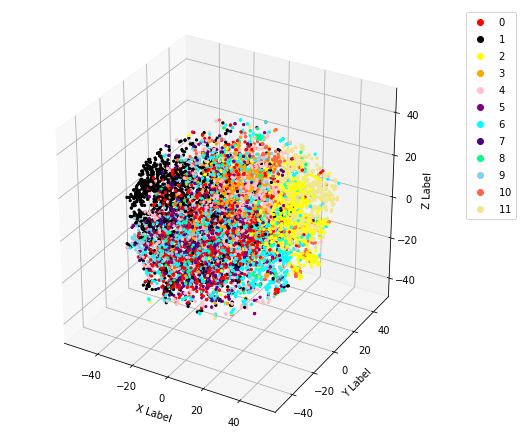

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = z[:,0]
y = z[:,1]
v = z[:,2]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn


cmap = ["red", "black",
        "yellow","blue",
        "orange", "pink",
        "gray", "purple",
        "cyan","green",
        "indigo", "springgreen",
        "crimson", "skyblue",
        "tomato","khaki" ]
cmap = ListedColormap(cmap)
print(sns.color_palette("husl", 256))


# plot
sc = ax.scatter(x, y, v, s=5, c=data["Label"] ,  cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
l = len(dataset_loader_drive.X)
# l = 1000

In [ ]:
import math
seprate_index = math.floor(0.8*l)
message_dataset_train = Message_Dataset(X[:seprate_index], Y[:seprate_index])
message_dataset_valid = Message_Dataset(X[seprate_index:l], Y[seprate_index:l])

In [ ]:
int(0.2*dataset_len)

1747

In [ ]:
data_loader_train = DataLoader(message_dataset_train,batch_size=16)
data_loader_valid = DataLoader(message_dataset_valid,batch_size=int(0.2*dataset_len)+1)

# classification model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data



from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
# class Messages_Classifier(nn.Module):
#     def __init__(self, vocab_size, embedding_size,num_of_class,max_len):
#       super(Messages_Classifier, self).__init__()
#       self.embedding = nn.Embedding(vocab_size, embedding_size)
#       self.fully_connected1= nn.Linear(embedding_size* max_len, 500)
#       self.dropout = nn.Dropout(0.3)
#       self.fully_connected2= nn.Linear(500, 300)
#       self.fully_connected3= nn.Linear(300, num_of_class)

#     def forward(self,x):
#       batch_size,input_l = x.size()
#       embed = self.embedding(x)
#       h1 = self.fully_connected1(embed.view(batch_size, -1))
#       d= self.dropout(h1)
#       h2 = self.fully_connected2(F.relu(d))
#       h3 = self.fully_connected3(F.relu(h2))
#       return h3
class Messages_Classifier(nn.Module):
    def __init__(self,  embedding_size,num_of_class,max_len):
      super(Messages_Classifier, self).__init__()
      # self.embedding = nn.Embedding(vocab_size, embedding_size)
      self.fully_connected1= nn.Linear(100, 50)
      self.dropout = nn.Dropout(0.2)
      self.fully_connected2= nn.Linear(50, 20)
      self.fully_connected3= nn.Linear(20
                                       , num_of_class)

    def forward(self,x):
      batch_size,input_l = x.size()
      # embed = self.embedding(x)
      h1 = self.fully_connected1(x)
      d= self.dropout(h1)
      h2 = self.fully_connected2(F.relu(d))
      h3 = self.fully_connected3(F.relu(h2))
      return h3

In [ ]:
model = Messages_Classifier(100,num_of_class,dataset_loader_drive.max_len)


In [ ]:
print(model
      )

Messages_Classifier(
  (fully_connected1): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=50, out_features=20, bias=True)
  (fully_connected3): Linear(in_features=20, out_features=12, bias=True)
)


In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
# print(optimizer.lr)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_fun = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fun = loss_fun.to(device)

In [ ]:
def accuracy_score(y_pred, y ):
    top_pred = y_pred.argmax(1, keepdim=True)
    # print(metrics.confusion_matrix(top_pred.cpu(),y.cpu()))
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True


In [ ]:
def train(model,train_data, optimizer, loss_fun):
   epoch_loss = 0
   epoch_acc = 0
   model.train()
   for (text, label) in tqdm(train_data):

      optimizer.zero_grad()

      x = text.to(device)
      y = label.to(device)

      output= model(x.float())

      loss = loss_fun(output,y)

      acc= accuracy_score(output, y)
      # print("**")
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  # if index == 1:
    #   print(len(iterator))
    #   print(metrics.classification_report(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    #   print(metrics.confusion_matrix(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
   return epoch_loss / len(train_data), epoch_acc / len(train_data)


In [ ]:
def evaluate(model, iterator, criterion, device,index=0):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
            print(x.shape)
            y_pred = model(x.float())

            loss = criterion(y_pred, y)

            acc = accuracy_score(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    top_pred = y_pred.argmax(1, keepdim=True)
    # if index == 1:
    #   print(len(iterator))
    #   print(metrics.classification_report(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    #   print(metrics.confusion_matrix(top_pred.cpu(),y.cpu(),labels = [i for i in range(20)]))
    return epoch_loss / len(iterator), epoch_acc / len(iterator), top_pred, y

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plot_confusion_matrix(con_matrix):
  df_cm = pd.DataFrame(con_matrix, range(num_of_class), range(num_of_class))
# plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.29      0.29      0.29       214
           1       0.62      0.83      0.71       319
           2       0.57      0.71      0.63       167
           3       0.00      0.00      0.00       133
           4       0.29      0.02      0.03       120
           5       0.00      0.00      0.00       123
           6       0.25      0.75      0.38       248
           7       0.00      0.00      0.00        83
           8       0.00      0.00      0.00        47
           9       0.00      0.00      0.00        57
          10       1.00      0.01      0.03        68
          11       0.85      0.68      0.76       169

    accuracy                           0.43      1748
   macro avg       0.32      0.28      0.24      1748
weighted avg       0.38      0.43      0.36      1748

	Train Loss: 2.011 | Train Acc: 31.40%
	 Val. Loss: 1.742 |  Val. Acc: 43.02%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.31      0.50      0.38       214
           1       0.70      0.81      0.75       319
           2       0.63      0.72      0.67       167
           3       0.00      0.00      0.00       133
           4       0.33      0.19      0.24       120
           5       0.00      0.00      0.00       123
           6       0.28      0.67      0.39       248
           7       0.00      0.00      0.00        83
           8       0.00      0.00      0.00        47
           9       0.00      0.00      0.00        57
          10       0.81      0.25      0.38        68
          11       0.86      0.72      0.78       169

    accuracy                           0.47      1748
   macro avg       0.33      0.32      0.30      1748
weighted avg       0.40      0.47      0.41      1748

	Train Loss: 1.681 | Train Acc: 43.80%
	 Val. Loss: 1.581 |  Val. Acc: 46.57%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.33      0.48      0.39       214
           1       0.71      0.81      0.76       319
           2       0.69      0.72      0.71       167
           3       0.00      0.00      0.00       133
           4       0.40      0.40      0.40       120
           5       0.00      0.00      0.00       123
           6       0.29      0.69      0.41       248
           7       0.56      0.06      0.11        83
           8       0.00      0.00      0.00        47
           9       1.00      0.12      0.22        57
          10       0.62      0.29      0.40        68
          11       0.86      0.76      0.81       169

    accuracy                           0.49      1748
   macro avg       0.46      0.36      0.35      1748
weighted avg       0.47      0.49      0.44      1748

	Train Loss: 1.554 | Train Acc: 47.06%
	 Val. Loss: 1.486 |  Val. Acc: 49.20%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.36      0.50      0.42       214
           1       0.75      0.79      0.77       319
           2       0.69      0.71      0.70       167
           3       0.60      0.11      0.19       133
           4       0.38      0.39      0.38       120
           5       0.00      0.00      0.00       123
           6       0.29      0.65      0.40       248
           7       0.35      0.10      0.15        83
           8       0.00      0.00      0.00        47
           9       0.61      0.33      0.43        57
          10       0.57      0.31      0.40        68
          11       0.87      0.78      0.82       169

    accuracy                           0.50      1748
   macro avg       0.46      0.39      0.39      1748
weighted avg       0.50      0.50      0.47      1748

	Train Loss: 1.475 | Train Acc: 49.96%
	 Val. Loss: 1.427 |  Val. Acc: 50.29%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.36      0.48      0.41       214
           1       0.74      0.79      0.76       319
           2       0.74      0.76      0.75       167
           3       0.65      0.31      0.42       133
           4       0.41      0.45      0.43       120
           5       0.00      0.00      0.00       123
           6       0.33      0.67      0.44       248
           7       0.46      0.16      0.23        83
           8       0.00      0.00      0.00        47
           9       0.54      0.44      0.49        57
          10       0.54      0.31      0.39        68
          11       0.91      0.77      0.83       169

    accuracy                           0.53      1748
   macro avg       0.47      0.43      0.43      1748
weighted avg       0.52      0.53      0.51      1748

	Train Loss: 1.424 | Train Acc: 52.07%
	 Val. Loss: 1.383 |  Val. Acc: 53.32%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.38      0.47      0.42       214
           1       0.74      0.78      0.76       319
           2       0.76      0.80      0.78       167
           3       0.64      0.39      0.49       133
           4       0.39      0.50      0.44       120
           5       0.00      0.00      0.00       123
           6       0.35      0.67      0.46       248
           7       0.41      0.19      0.26        83
           8       0.00      0.00      0.00        47
           9       0.53      0.47      0.50        57
          10       0.65      0.29      0.40        68
          11       0.92      0.80      0.86       169

    accuracy                           0.55      1748
   macro avg       0.48      0.45      0.45      1748
weighted avg       0.53      0.55      0.52      1748

	Train Loss: 1.379 | Train Acc: 54.44%
	 Val. Loss: 1.347 |  Val. Acc: 54.81%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       214
           1       0.76      0.78      0.77       319
           2       0.75      0.82      0.78       167
           3       0.66      0.44      0.52       133
           4       0.43      0.49      0.46       120
           5       0.29      0.02      0.03       123
           6       0.37      0.70      0.48       248
           7       0.41      0.18      0.25        83
           8       0.00      0.00      0.00        47
           9       0.52      0.47      0.50        57
          10       0.56      0.29      0.38        68
          11       0.93      0.78      0.85       169

    accuracy                           0.56      1748
   macro avg       0.51      0.46      0.46      1748
weighted avg       0.56      0.56      0.54      1748

	Train Loss: 1.336 | Train Acc: 55.95%
	 Val. Loss: 1.326 |  Val. Acc: 56.24%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.56      0.49       214
           1       0.78      0.77      0.78       319
           2       0.72      0.82      0.77       167
           3       0.65      0.46      0.54       133
           4       0.44      0.56      0.49       120
           5       0.40      0.02      0.03       123
           6       0.39      0.69      0.50       248
           7       0.45      0.27      0.33        83
           8       0.00      0.00      0.00        47
           9       0.54      0.53      0.53        57
          10       0.56      0.26      0.36        68
          11       0.94      0.76      0.84       169

    accuracy                           0.57      1748
   macro avg       0.53      0.47      0.47      1748
weighted avg       0.58      0.57      0.55      1748

	Train Loss: 1.307 | Train Acc: 55.81%
	 Val. Loss: 1.314 |  Val. Acc: 57.32%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.46      0.57      0.51       214
           1       0.78      0.77      0.78       319
           2       0.77      0.81      0.79       167
           3       0.63      0.49      0.55       133
           4       0.46      0.57      0.51       120
           5       0.30      0.02      0.05       123
           6       0.39      0.69      0.50       248
           7       0.47      0.23      0.31        83
           8       0.00      0.00      0.00        47
           9       0.54      0.49      0.51        57
          10       0.54      0.32      0.40        68
          11       0.91      0.85      0.88       169

    accuracy                           0.58      1748
   macro avg       0.52      0.48      0.48      1748
weighted avg       0.58      0.58      0.56      1748

	Train Loss: 1.291 | Train Acc: 56.97%
	 Val. Loss: 1.291 |  Val. Acc: 58.47%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       214
           1       0.78      0.76      0.77       319
           2       0.75      0.80      0.77       167
           3       0.63      0.55      0.59       133
           4       0.48      0.50      0.49       120
           5       0.36      0.04      0.07       123
           6       0.39      0.68      0.49       248
           7       0.42      0.27      0.32        83
           8       0.00      0.00      0.00        47
           9       0.45      0.51      0.48        57
          10       0.69      0.32      0.44        68
          11       0.93      0.83      0.87       169

    accuracy                           0.58      1748
   macro avg       0.52      0.48      0.48      1748
weighted avg       0.58      0.58      0.56      1748

	Train Loss: 1.269 | Train Acc: 57.77%
	 Val. Loss: 1.282 |  Val. Acc: 57.89%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.57      0.50       214
           1       0.79      0.76      0.77       319
           2       0.76      0.83      0.79       167
           3       0.61      0.55      0.58       133
           4       0.49      0.52      0.50       120
           5       0.34      0.10      0.15       123
           6       0.41      0.65      0.51       248
           7       0.39      0.27      0.32        83
           8       0.00      0.00      0.00        47
           9       0.50      0.49      0.50        57
          10       0.55      0.38      0.45        68
          11       0.91      0.83      0.87       169

    accuracy                           0.59      1748
   macro avg       0.52      0.49      0.49      1748
weighted avg       0.58      0.59      0.57      1748

	Train Loss: 1.248 | Train Acc: 58.49%
	 Val. Loss: 1.270 |  Val. Acc: 58.70%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       214
           1       0.78      0.76      0.77       319
           2       0.74      0.83      0.78       167
           3       0.62      0.51      0.56       133
           4       0.47      0.50      0.48       120
           5       0.35      0.12      0.18       123
           6       0.42      0.67      0.51       248
           7       0.43      0.28      0.34        83
           8       0.00      0.00      0.00        47
           9       0.56      0.49      0.52        57
          10       0.52      0.37      0.43        68
          11       0.93      0.83      0.87       169

    accuracy                           0.59      1748
   macro avg       0.52      0.49      0.50      1748
weighted avg       0.58      0.59      0.57      1748

	Train Loss: 1.235 | Train Acc: 58.92%
	 Val. Loss: 1.267 |  Val. Acc: 58.58%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.54      0.49       214
           1       0.78      0.76      0.77       319
           2       0.78      0.80      0.79       167
           3       0.62      0.53      0.57       133
           4       0.48      0.51      0.49       120
           5       0.37      0.15      0.21       123
           6       0.41      0.68      0.51       248
           7       0.40      0.28      0.33        83
           8       0.00      0.00      0.00        47
           9       0.49      0.51      0.50        57
          10       0.59      0.35      0.44        68
          11       0.92      0.85      0.88       169

    accuracy                           0.59      1748
   macro avg       0.52      0.50      0.50      1748
weighted avg       0.58      0.59      0.57      1748

	Train Loss: 1.222 | Train Acc: 59.49%
	 Val. Loss: 1.261 |  Val. Acc: 58.75%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       214
           1       0.80      0.74      0.77       319
           2       0.77      0.83      0.80       167
           3       0.60      0.55      0.57       133
           4       0.48      0.53      0.50       120
           5       0.39      0.18      0.25       123
           6       0.42      0.65      0.51       248
           7       0.39      0.29      0.33        83
           8       0.00      0.00      0.00        47
           9       0.48      0.49      0.49        57
          10       0.60      0.35      0.44        68
          11       0.93      0.84      0.88       169

    accuracy                           0.59      1748
   macro avg       0.53      0.50      0.50      1748
weighted avg       0.59      0.59      0.58      1748

	Train Loss: 1.206 | Train Acc: 59.91%
	 Val. Loss: 1.257 |  Val. Acc: 58.92%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.57      0.50       214
           1       0.78      0.76      0.77       319
           2       0.76      0.83      0.79       167
           3       0.61      0.56      0.59       133
           4       0.46      0.54      0.50       120
           5       0.42      0.18      0.25       123
           6       0.43      0.62      0.51       248
           7       0.46      0.31      0.37        83
           8       0.00      0.00      0.00        47
           9       0.52      0.51      0.51        57
          10       0.59      0.35      0.44        68
          11       0.93      0.83      0.88       169

    accuracy                           0.60      1748
   macro avg       0.53      0.51      0.51      1748
weighted avg       0.59      0.60      0.58      1748

	Train Loss: 1.196 | Train Acc: 60.07%
	 Val. Loss: 1.250 |  Val. Acc: 59.55%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       214
           1       0.80      0.76      0.78       319
           2       0.78      0.81      0.80       167
           3       0.56      0.58      0.57       133
           4       0.50      0.53      0.52       120
           5       0.38      0.17      0.23       123
           6       0.45      0.62      0.52       248
           7       0.47      0.31      0.38        83
           8       1.00      0.02      0.04        47
           9       0.49      0.51      0.50        57
          10       0.52      0.41      0.46        68
          11       0.93      0.84      0.88       169

    accuracy                           0.60      1748
   macro avg       0.61      0.51      0.52      1748
weighted avg       0.62      0.60      0.59      1748

	Train Loss: 1.185 | Train Acc: 61.11%
	 Val. Loss: 1.250 |  Val. Acc: 59.90%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.43      0.59      0.50       214
           1       0.81      0.75      0.78       319
           2       0.77      0.80      0.79       167
           3       0.56      0.59      0.57       133
           4       0.48      0.57      0.52       120
           5       0.38      0.19      0.25       123
           6       0.46      0.62      0.53       248
           7       0.45      0.34      0.39        83
           8       1.00      0.02      0.04        47
           9       0.58      0.49      0.53        57
          10       0.63      0.35      0.45        68
          11       0.90      0.84      0.87       169

    accuracy                           0.60      1748
   macro avg       0.62      0.51      0.52      1748
weighted avg       0.62      0.60      0.59      1748

	Train Loss: 1.175 | Train Acc: 61.10%
	 Val. Loss: 1.240 |  Val. Acc: 59.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.57      0.50       214
           1       0.79      0.76      0.78       319
           2       0.76      0.83      0.79       167
           3       0.58      0.60      0.59       133
           4       0.49      0.53      0.51       120
           5       0.37      0.20      0.26       123
           6       0.47      0.62      0.53       248
           7       0.44      0.34      0.38        83
           8       1.00      0.02      0.04        47
           9       0.48      0.49      0.49        57
          10       0.56      0.43      0.48        68
          11       0.93      0.83      0.88       169

    accuracy                           0.60      1748
   macro avg       0.61      0.52      0.52      1748
weighted avg       0.62      0.60      0.59      1748

	Train Loss: 1.173 | Train Acc: 61.11%
	 Val. Loss: 1.236 |  Val. Acc: 60.07%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.59      0.51       214
           1       0.79      0.77      0.78       319
           2       0.78      0.81      0.80       167
           3       0.62      0.56      0.59       133
           4       0.48      0.57      0.52       120
           5       0.36      0.15      0.22       123
           6       0.44      0.62      0.52       248
           7       0.48      0.31      0.38        83
           8       1.00      0.02      0.04        47
           9       0.53      0.51      0.52        57
          10       0.55      0.41      0.47        68
          11       0.91      0.85      0.88       169

    accuracy                           0.60      1748
   macro avg       0.62      0.52      0.52      1748
weighted avg       0.62      0.60      0.59      1748

	Train Loss: 1.158 | Train Acc: 61.35%
	 Val. Loss: 1.233 |  Val. Acc: 60.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.150 | Train Acc: 61.80%
	 Val. Loss: 1.233 |  Val. Acc: 59.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.43      0.61      0.51       214
           1       0.81      0.74      0.77       319
           2       0.77      0.82      0.79       167
           3       0.55      0.64      0.59       133
           4       0.47      0.52      0.49       120
           5       0.33      0.18      0.23       123
           6       0.48      0.57      0.52       248
           7       0.43      0.34      0.38        83
           8       0.50      0.02      0.04        47
           9       0.55      0.49      0.52        57
          10       0.54      0.40      0.46        68
          11       0.91      0.85      0.88       169

    accuracy                           0.60      1748
   macro avg       0.56      0.51      0.52      1748
weighted avg       0.60      0.60      0.59      1748

	Train Loss: 1.141 | Train Acc: 62.17%
	 Val. Loss: 1.225 |  Val. Acc: 59.67%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.45      0.63      0.53       214
           1       0.79      0.77      0.78       319
           2       0.77      0.82      0.79       167
           3       0.59      0.60      0.59       133
           4       0.47      0.55      0.51       120
           5       0.38      0.20      0.26       123
           6       0.48      0.58      0.52       248
           7       0.48      0.39      0.43        83
           8       0.40      0.04      0.08        47
           9       0.58      0.49      0.53        57
          10       0.59      0.38      0.46        68
          11       0.91      0.85      0.88       169

    accuracy                           0.61      1748
   macro avg       0.57      0.52      0.53      1748
weighted avg       0.61      0.61      0.60      1748

	Train Loss: 1.137 | Train Acc: 61.77%
	 Val. Loss: 1.223 |  Val. Acc: 60.70%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.130 | Train Acc: 61.68%
	 Val. Loss: 1.226 |  Val. Acc: 60.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.120 | Train Acc: 62.60%
	 Val. Loss: 1.224 |  Val. Acc: 60.64%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.46      0.59      0.52       214
           1       0.81      0.75      0.78       319
           2       0.77      0.83      0.80       167
           3       0.56      0.62      0.59       133
           4       0.45      0.55      0.49       120
           5       0.34      0.21      0.26       123
           6       0.48      0.58      0.53       248
           7       0.44      0.34      0.38        83
           8       0.33      0.04      0.08        47
           9       0.58      0.53      0.55        57
          10       0.53      0.34      0.41        68
          11       0.91      0.86      0.88       169

    accuracy                           0.60      1748
   macro avg       0.56      0.52      0.52      1748
weighted avg       0.60      0.60      0.59      1748

	Train Loss: 1.114 | Train Acc: 62.59%
	 Val. Loss: 1.217 |  Val. Acc: 60.18%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.108 | Train Acc: 62.84%
	 Val. Loss: 1.224 |  Val. Acc: 60.98%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.096 | Train Acc: 63.36%
	 Val. Loss: 1.220 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       214
           1       0.82      0.75      0.78       319
           2       0.80      0.84      0.82       167
           3       0.58      0.57      0.58       133
           4       0.48      0.55      0.51       120
           5       0.36      0.22      0.27       123
           6       0.51      0.59      0.54       248
           7       0.46      0.40      0.43        83
           8       0.25      0.04      0.07        47
           9       0.57      0.53      0.55        57
          10       0.53      0.41      0.46        68
          11       0.90      0.92      0.91       169

    accuracy                           0.62      1748
   macro avg       0.56      0.54      0.54      1748
weighted avg       0.61      0.62      0.61      1748

	Train Loss: 1.089 | Train Acc: 63.37%
	 Val. Loss: 1.216 |  Val. Acc: 61.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.44      0.62      0.51       214
           1       0.79      0.75      0.77       319
           2       0.78      0.82      0.80       167
           3       0.59      0.59      0.59       133
           4       0.48      0.53      0.51       120
           5       0.37      0.21      0.27       123
           6       0.51      0.57      0.54       248
           7       0.44      0.40      0.42        83
           8       0.43      0.06      0.11        47
           9       0.53      0.53      0.53        57
          10       0.56      0.44      0.49        68
          11       0.93      0.89      0.91       169

    accuracy                           0.61      1748
   macro avg       0.57      0.53      0.54      1748
weighted avg       0.61      0.61      0.60      1748

	Train Loss: 1.089 | Train Acc: 63.89%
	 Val. Loss: 1.213 |  Val. Acc: 60.98%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.083 | Train Acc: 63.77%
	 Val. Loss: 1.213 |  Val. Acc: 61.16%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.072 | Train Acc: 64.49%
	 Val. Loss: 1.216 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.075 | Train Acc: 64.45%
	 Val. Loss: 1.219 |  Val. Acc: 61.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.47      0.64      0.54       214
           1       0.81      0.76      0.78       319
           2       0.81      0.81      0.81       167
           3       0.59      0.60      0.60       133
           4       0.50      0.53      0.51       120
           5       0.36      0.24      0.29       123
           6       0.49      0.60      0.54       248
           7       0.51      0.34      0.41        83
           8       0.33      0.06      0.11        47
           9       0.55      0.54      0.55        57
          10       0.55      0.44      0.49        68
          11       0.90      0.91      0.90       169

    accuracy                           0.62      1748
   macro avg       0.57      0.54      0.54      1748
weighted avg       0.62      0.62      0.61      1748

	Train Loss: 1.065 | Train Acc: 64.68%
	 Val. Loss: 1.212 |  Val. Acc: 61.90%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.061 | Train Acc: 64.78%
	 Val. Loss: 1.213 |  Val. Acc: 61.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.056 | Train Acc: 64.52%
	 Val. Loss: 1.218 |  Val. Acc: 61.44%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.042 | Train Acc: 65.16%
	 Val. Loss: 1.215 |  Val. Acc: 61.61%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.039 | Train Acc: 64.95%
	 Val. Loss: 1.213 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.49      0.64      0.55       214
           1       0.81      0.73      0.77       319
           2       0.82      0.83      0.83       167
           3       0.59      0.57      0.58       133
           4       0.50      0.53      0.51       120
           5       0.36      0.19      0.25       123
           6       0.46      0.62      0.53       248
           7       0.48      0.36      0.41        83
           8       0.40      0.09      0.14        47
           9       0.56      0.58      0.57        57
          10       0.57      0.41      0.48        68
          11       0.90      0.95      0.92       169

    accuracy                           0.62      1748
   macro avg       0.58      0.54      0.54      1748
weighted avg       0.62      0.62      0.61      1748

	Train Loss: 1.035 | Train Acc: 65.21%
	 Val. Loss: 1.211 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.031 | Train Acc: 65.38%
	 Val. Loss: 1.213 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.48      0.64      0.55       214
           1       0.80      0.75      0.77       319
           2       0.84      0.82      0.83       167
           3       0.60      0.60      0.60       133
           4       0.50      0.51      0.51       120
           5       0.33      0.20      0.24       123
           6       0.48      0.60      0.54       248
           7       0.48      0.37      0.42        83
           8       0.36      0.09      0.14        47
           9       0.55      0.58      0.56        57
          10       0.56      0.43      0.48        68
          11       0.90      0.94      0.92       169

    accuracy                           0.62      1748
   macro avg       0.57      0.54      0.55      1748
weighted avg       0.62      0.62      0.61      1748

	Train Loss: 1.032 | Train Acc: 65.29%
	 Val. Loss: 1.209 |  Val. Acc: 62.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.029 | Train Acc: 64.78%
	 Val. Loss: 1.216 |  Val. Acc: 62.19%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.020 | Train Acc: 65.89%
	 Val. Loss: 1.218 |  Val. Acc: 62.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.016 | Train Acc: 65.78%
	 Val. Loss: 1.209 |  Val. Acc: 62.76%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.011 | Train Acc: 65.73%
	 Val. Loss: 1.215 |  Val. Acc: 61.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.009 | Train Acc: 65.70%
	 Val. Loss: 1.218 |  Val. Acc: 61.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.998 | Train Acc: 66.12%
	 Val. Loss: 1.218 |  Val. Acc: 62.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 1.002 | Train Acc: 65.89%
	 Val. Loss: 1.209 |  Val. Acc: 62.24%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.993 | Train Acc: 66.33%
	 Val. Loss: 1.219 |  Val. Acc: 62.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.986 | Train Acc: 66.71%
	 Val. Loss: 1.225 |  Val. Acc: 62.19%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.988 | Train Acc: 66.68%
	 Val. Loss: 1.221 |  Val. Acc: 61.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.992 | Train Acc: 66.38%
	 Val. Loss: 1.222 |  Val. Acc: 62.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.976 | Train Acc: 67.04%
	 Val. Loss: 1.225 |  Val. Acc: 62.64%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.970 | Train Acc: 67.35%
	 Val. Loss: 1.221 |  Val. Acc: 62.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.974 | Train Acc: 67.15%
	 Val. Loss: 1.225 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.975 | Train Acc: 66.91%
	 Val. Loss: 1.230 |  Val. Acc: 61.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.970 | Train Acc: 67.14%
	 Val. Loss: 1.227 |  Val. Acc: 61.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.959 | Train Acc: 67.62%
	 Val. Loss: 1.238 |  Val. Acc: 62.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.958 | Train Acc: 67.61%
	 Val. Loss: 1.233 |  Val. Acc: 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.966 | Train Acc: 67.19%
	 Val. Loss: 1.233 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.953 | Train Acc: 67.59%
	 Val. Loss: 1.231 |  Val. Acc: 61.67%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.955 | Train Acc: 67.59%
	 Val. Loss: 1.234 |  Val. Acc: 62.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.956 | Train Acc: 67.36%
	 Val. Loss: 1.241 |  Val. Acc: 61.61%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.947 | Train Acc: 68.19%
	 Val. Loss: 1.247 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.944 | Train Acc: 67.71%
	 Val. Loss: 1.241 |  Val. Acc: 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.941 | Train Acc: 67.98%
	 Val. Loss: 1.243 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.938 | Train Acc: 68.44%
	 Val. Loss: 1.249 |  Val. Acc: 62.36%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.927 | Train Acc: 68.64%
	 Val. Loss: 1.245 |  Val. Acc: 61.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.931 | Train Acc: 68.57%
	 Val. Loss: 1.247 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.936 | Train Acc: 68.43%
	 Val. Loss: 1.242 |  Val. Acc: 61.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.936 | Train Acc: 68.88%
	 Val. Loss: 1.247 |  Val. Acc: 62.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.920 | Train Acc: 68.39%
	 Val. Loss: 1.250 |  Val. Acc: 62.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.918 | Train Acc: 69.09%
	 Val. Loss: 1.256 |  Val. Acc: 62.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.923 | Train Acc: 68.54%
	 Val. Loss: 1.261 |  Val. Acc: 62.41%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.903 | Train Acc: 68.74%
	 Val. Loss: 1.265 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.920 | Train Acc: 68.60%
	 Val. Loss: 1.260 |  Val. Acc: 62.24%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.913 | Train Acc: 68.94%
	 Val. Loss: 1.267 |  Val. Acc: 62.19%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.914 | Train Acc: 68.78%
	 Val. Loss: 1.264 |  Val. Acc: 61.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.907 | Train Acc: 68.81%
	 Val. Loss: 1.268 |  Val. Acc: 61.61%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.912 | Train Acc: 69.18%
	 Val. Loss: 1.272 |  Val. Acc: 61.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.916 | Train Acc: 69.29%
	 Val. Loss: 1.263 |  Val. Acc: 62.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.899 | Train Acc: 69.41%
	 Val. Loss: 1.275 |  Val. Acc: 61.90%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.893 | Train Acc: 69.84%
	 Val. Loss: 1.280 |  Val. Acc: 61.61%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.903 | Train Acc: 69.11%
	 Val. Loss: 1.274 |  Val. Acc: 61.21%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.892 | Train Acc: 69.19%
	 Val. Loss: 1.284 |  Val. Acc: 61.38%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.898 | Train Acc: 69.03%
	 Val. Loss: 1.284 |  Val. Acc: 61.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.896 | Train Acc: 69.75%
	 Val. Loss: 1.283 |  Val. Acc: 61.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.900 | Train Acc: 69.56%
	 Val. Loss: 1.276 |  Val. Acc: 61.33%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.891 | Train Acc: 69.37%
	 Val. Loss: 1.288 |  Val. Acc: 61.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.880 | Train Acc: 69.57%
	 Val. Loss: 1.291 |  Val. Acc: 61.33%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.880 | Train Acc: 69.79%
	 Val. Loss: 1.291 |  Val. Acc: 61.16%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.882 | Train Acc: 69.92%
	 Val. Loss: 1.288 |  Val. Acc: 61.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.877 | Train Acc: 69.93%
	 Val. Loss: 1.287 |  Val. Acc: 61.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.879 | Train Acc: 70.15%
	 Val. Loss: 1.294 |  Val. Acc: 61.84%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.874 | Train Acc: 69.98%
	 Val. Loss: 1.292 |  Val. Acc: 60.98%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.881 | Train Acc: 69.88%
	 Val. Loss: 1.296 |  Val. Acc: 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.873 | Train Acc: 70.04%
	 Val. Loss: 1.304 |  Val. Acc: 61.21%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.871 | Train Acc: 70.16%
	 Val. Loss: 1.300 |  Val. Acc: 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.876 | Train Acc: 69.86%
	 Val. Loss: 1.306 |  Val. Acc: 61.67%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.878 | Train Acc: 69.44%
	 Val. Loss: 1.312 |  Val. Acc: 61.21%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.873 | Train Acc: 70.17%
	 Val. Loss: 1.314 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.858 | Train Acc: 70.73%
	 Val. Loss: 1.331 |  Val. Acc: 61.10%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.856 | Train Acc: 70.11%
	 Val. Loss: 1.315 |  Val. Acc: 61.67%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.865 | Train Acc: 70.17%
	 Val. Loss: 1.319 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.868 | Train Acc: 70.16%
	 Val. Loss: 1.331 |  Val. Acc: 60.81%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.857 | Train Acc: 70.67%
	 Val. Loss: 1.317 |  Val. Acc: 61.44%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.860 | Train Acc: 70.43%
	 Val. Loss: 1.315 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.855 | Train Acc: 70.44%
	 Val. Loss: 1.326 |  Val. Acc: 61.44%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.853 | Train Acc: 70.58%
	 Val. Loss: 1.331 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.845 | Train Acc: 71.03%
	 Val. Loss: 1.334 |  Val. Acc: 61.27%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.842 | Train Acc: 71.21%
	 Val. Loss: 1.342 |  Val. Acc: 61.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.845 | Train Acc: 71.14%
	 Val. Loss: 1.363 |  Val. Acc: 59.95%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.853 | Train Acc: 71.17%
	 Val. Loss: 1.347 |  Val. Acc: 60.47%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.842 | Train Acc: 70.81%
	 Val. Loss: 1.339 |  Val. Acc: 61.10%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.842 | Train Acc: 70.91%
	 Val. Loss: 1.340 |  Val. Acc: 60.76%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.841 | Train Acc: 71.37%
	 Val. Loss: 1.349 |  Val. Acc: 61.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.845 | Train Acc: 70.88%
	 Val. Loss: 1.348 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.842 | Train Acc: 70.42%
	 Val. Loss: 1.356 |  Val. Acc: 61.16%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.848 | Train Acc: 70.50%
	 Val. Loss: 1.352 |  Val. Acc: 61.21%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.840 | Train Acc: 71.16%
	 Val. Loss: 1.364 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.835 | Train Acc: 71.18%
	 Val. Loss: 1.367 |  Val. Acc: 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.843 | Train Acc: 70.96%
	 Val. Loss: 1.352 |  Val. Acc: 60.81%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.840 | Train Acc: 70.59%
	 Val. Loss: 1.375 |  Val. Acc: 60.35%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.823 | Train Acc: 71.51%
	 Val. Loss: 1.363 |  Val. Acc: 60.24%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.831 | Train Acc: 71.03%
	 Val. Loss: 1.367 |  Val. Acc: 60.24%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.836 | Train Acc: 71.07%
	 Val. Loss: 1.371 |  Val. Acc: 60.76%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.815 | Train Acc: 72.12%
	 Val. Loss: 1.377 |  Val. Acc: 60.41%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.831 | Train Acc: 71.31%
	 Val. Loss: 1.383 |  Val. Acc: 59.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.828 | Train Acc: 71.40%
	 Val. Loss: 1.377 |  Val. Acc: 60.47%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.823 | Train Acc: 71.43%
	 Val. Loss: 1.379 |  Val. Acc: 60.93%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.822 | Train Acc: 71.57%
	 Val. Loss: 1.382 |  Val. Acc: 60.01%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.826 | Train Acc: 71.09%
	 Val. Loss: 1.388 |  Val. Acc: 60.13%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.819 | Train Acc: 71.63%
	 Val. Loss: 1.389 |  Val. Acc: 60.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.815 | Train Acc: 71.77%
	 Val. Loss: 1.406 |  Val. Acc: 60.30%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.819 | Train Acc: 72.07%
	 Val. Loss: 1.409 |  Val. Acc: 60.35%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.816 | Train Acc: 71.93%
	 Val. Loss: 1.407 |  Val. Acc: 59.61%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.829 | Train Acc: 71.31%
	 Val. Loss: 1.404 |  Val. Acc: 60.18%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.823 | Train Acc: 71.46%
	 Val. Loss: 1.397 |  Val. Acc: 60.18%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.811 | Train Acc: 72.18%
	 Val. Loss: 1.406 |  Val. Acc: 60.41%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.822 | Train Acc: 71.46%
	 Val. Loss: 1.410 |  Val. Acc: 60.35%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.809 | Train Acc: 71.96%
	 Val. Loss: 1.404 |  Val. Acc: 60.70%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.808 | Train Acc: 71.84%
	 Val. Loss: 1.424 |  Val. Acc: 60.81%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.813 | Train Acc: 71.81%
	 Val. Loss: 1.439 |  Val. Acc: 60.07%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.812 | Train Acc: 71.65%
	 Val. Loss: 1.420 |  Val. Acc: 60.18%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
	Train Loss: 0.805 | Train Acc: 72.55%
	 Val. Loss: 1.423 |  Val. Acc: 60.64%


  0%|          | 0/437 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
We are at epoch: 144


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([6990, 100])
              precision    recall  f1-score   support

           0       0.60      0.77      0.68       889
           1       0.92      0.89      0.90      1254
           2       0.92      0.92      0.92       673
           3       0.68      0.85      0.75       443
           4       0.76      0.69      0.72       651
           5       0.68      0.49      0.57       439
           6       0.72      0.76      0.73       992
           7       0.76      0.62      0.68       319
           8       0.67      0.40      0.50       173
           9       0.74      0.70      0.72       269
          10       0.88      0.67      0.76       319
          11       0.95      0.99      0.97       569

    accuracy                           0.78      6990
   macro avg       0.77      0.73      0.74      6990
weighted avg       0.79      0.78      0.78      6990



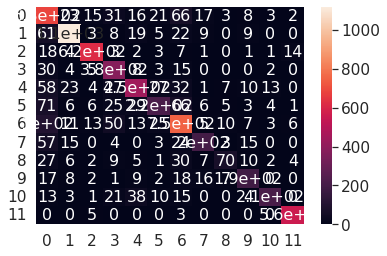

None


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1748, 100])
              precision    recall  f1-score   support

           0       0.43      0.62      0.51       214
           1       0.80      0.74      0.77       319
           2       0.79      0.82      0.81       167
           3       0.54      0.62      0.58       133
           4       0.47      0.49      0.48       120
           5       0.35      0.24      0.28       123
           6       0.52      0.54      0.53       248
           7       0.44      0.30      0.36        83
           8       0.33      0.19      0.24        47
           9       0.57      0.49      0.53        57
          10       0.48      0.35      0.41        68
          11       0.92      0.92      0.92       169

    accuracy                           0.60      1748
   macro avg       0.55      0.53      0.53      1748
weighted avg       0.60      0.60      0.60      1748



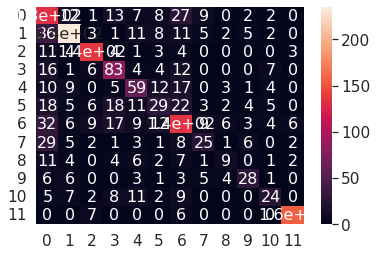

None
144
	Train Loss: 0.810 | Train Acc: 71.50%
	 Val. Loss: 1.423 |  Val. Acc: 60.24%


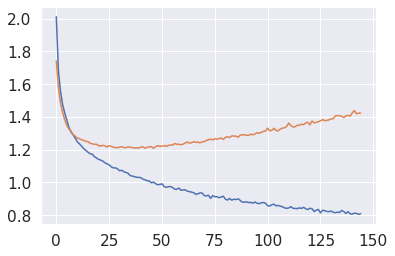

In [ ]:
EPOCHS = 500
early_stopping = EarlyStopping(tolerance=5, min_delta=0.6)
best_valid_loss = float('inf')
loss_per_epoch_train = []
loss_per_epoch_valid = []
for epoch in tqdm(range(EPOCHS)):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, data_loader_train, optimizer, loss_fun)
    valid_loss, valid_acc ,y_pred, y  = evaluate(model, data_loader_valid, loss_fun, device, 1 if epoch == EPOCHS-1 else 0)
    loss_per_epoch_train.append(train_loss)
    loss_per_epoch_valid.append(valid_loss)
    early_stopping(train_loss, valid_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      data_loader_train = DataLoader(message_dataset_train,batch_size=int(l*0.8)+1,shuffle=True)
      valid_loss, valid_acc,y_pred, y  = evaluate(model, data_loader_train, loss_fun, device, 1 )
      print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
      print(plot_confusion_matrix(con_matrix=mt.confusion_matrix(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)])))

      valid_loss, valid_acc,y_pred, y  = evaluate(model, data_loader_valid, loss_fun, device, 1 )
      print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
      print(plot_confusion_matrix(con_matrix=mt.confusion_matrix(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)])))
      print(epoch)
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      break
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
        print(mt.classification_report(y.cpu(),y_pred.cpu(),labels = [i for i in range(num_of_class)]))
    end_time = time.monotonic()
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
y_pred.cpu().numpy().reshape(1,-1).squeeze()

array([ 6, 11,  0, ..., 11,  1,  4])

In [ ]:

pd.DataFrame({"message":Text[int(dataset_len * 0.8):],"true":y.cpu().numpy().reshape(1,-1).squeeze(),"predict":y_pred.cpu().numpy().reshape(1,-1).squeeze()}).to_excel("ANN_label_result.xlsx")